# Proyecto curso de Bigdata
Lo primero de todo es importar las bibliotecas necesarias


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col
import json
import pytest
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-memory 10g pyspark-shell'

import numpy as np
import matplotlib
!pip install ipytest
import ipytest

import pyspark

import pandas as pd

ipytest.autoconfig()



In [2]:

spark = SparkSession.builder.appName("Proyecto-Big-Data").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/31 23:39:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


## Preparación de los datos
Los dos dataset que elegí son del Departamento de Salud de California, uno sobre el desempleo de la región y el otro sobre la asequibilidad de los alimentos, el proposito es ver como se relacionan entre sí.  
En este paso vamos a crear una función que lea los json y otra para crear los esquemas

In [3]:
def leer_json(ruta_archivo):
    with open(ruta_archivo, 'r') as f:
        return json.load(f)

def crear_esquema(campos):
    mapeo_tipos = {
        "int": IntegerType(),
        "text": StringType()
    }
    return StructType([
        StructField(campo['id'], mapeo_tipos.get(campo['type'], StringType()), True)
        for campo in campos
    ])

Una vez cargado los datos generamos un Dataframe con la funcionalidad de Pyspark y otra función que realice casting de tipos de datos en cada columna

In [4]:
def crear_dataframe(spark, registros, esquema):
    rdd = spark.sparkContext.parallelize(registros)
    return spark.createDataFrame(rdd, esquema)

def convertir_tipos(df, campos):
    mapeo_tipos = {
        "int": IntegerType(),
        "text": StringType()
    }
    for campo in campos:
        tipo_spark = mapeo_tipos.get(campo['type'], StringType())
        df = df.withColumn(campo['id'], col(campo['id']).cast(tipo_spark))
    return df



### Limpieza
Necesitamos realizar una limpieza de los datos, ádemas realizamos un print para saber que si hay datos siendo procesados

In [5]:
def limpiar_dataframe(df): #Limpieza básica nada muy complejo
    df = df.dropDuplicates()
    return df.na.fill("Desconocido")

def validar_carga(df, nombre_dataset): #prints
    print(f"\nValidación de {nombre_dataset}:")
    print(f"- Registros cargados: {df.count()}")
    print(f"- Columnas: {len(df.columns)}")
    df.printSchema()
    return df

### Carga
Por último juntamos en una función todos los distintos procesos que estamos realizando,aqui mismo vamos a correr los procesos para ambos datasets


In [6]:

def cargar_dataset(ruta_archivo, spark, nombre_dataset):
    datos_crudos = leer_json(ruta_archivo)
    campos = datos_crudos['fields']
    registros = datos_crudos['records']  
    esquema = crear_esquema(campos)
    df = crear_dataframe(spark, registros, esquema)
    df = convertir_tipos(df, campos)
    df = limpiar_dataframe(df)
    return validar_carga(df, nombre_dataset)


#Carga de datasets
spark = SparkSession.builder.appName("CargaDatos").getOrCreate()

# Carga modularizada de datasets
df_comida = cargar_dataset("comida.json", spark, "Datos de Comida")
df_desempleo = cargar_dataset("desempleo.json", spark, "Datos de Desempleo")

25/07/31 23:40:01 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.



Validación de Datos de Comida:


- Registros cargados: 14365
- Columnas: 24
root
 |-- _id: integer (nullable = true)
 |-- ind_id: string (nullable = false)
 |-- ind_definition: string (nullable = false)
 |-- reportyear: string (nullable = false)
 |-- race_eth_code: string (nullable = false)
 |-- race_eth_name: string (nullable = false)
 |-- geotype: string (nullable = false)
 |-- geotypevalue: string (nullable = false)
 |-- geoname: string (nullable = false)
 |-- county_name: string (nullable = false)
 |-- county_fips: string (nullable = false)
 |-- region_name: string (nullable = false)
 |-- region_code: string (nullable = false)
 |-- cost_yr: string (nullable = false)
 |-- median_income: string (nullable = false)
 |-- affordability_ratio: string (nullable = false)
 |-- LL95_affordability_ratio: string (nullable = false)
 |-- UL95_affordability_ratio: string (nullable = false)
 |-- se_food_afford: string (nullable = false)
 |-- rse_food_afford: string (nullable = false)
 |-- food_afford_decile: string (nullable = fal

25/07/31 23:40:07 WARN TaskSetManager: Stage 6 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


- Registros cargados: 106411
- Columnas: 23
root
 |-- _id: integer (nullable = true)
 |-- ind_id: string (nullable = false)
 |-- ind_definition: string (nullable = false)
 |-- reportyear: string (nullable = false)
 |-- race_eth_code: string (nullable = false)
 |-- race_eth_name: string (nullable = false)
 |-- geotype: string (nullable = false)
 |-- geotypevalue: string (nullable = false)
 |-- geoname: string (nullable = false)
 |-- county_fips: string (nullable = false)
 |-- county_name: string (nullable = false)
 |-- region_code: string (nullable = false)
 |-- region_name: string (nullable = false)
 |-- Unemployment: string (nullable = false)
 |-- Labor_force: string (nullable = false)
 |-- Unemployment_rate: string (nullable = false)
 |-- ll_95ci: string (nullable = false)
 |-- ul_95ci: string (nullable = false)
 |-- se: string (nullable = false)
 |-- rse: string (nullable = false)
 |-- place_decile: string (nullable = false)
 |-- ca_rr: string (nullable = false)
 |-- version: string

## Pruebas unitarias 
Parte de la verificación necesaria para poder comprobar que todo se importo correctamente es la de hacer pruebas en pytests.
Estas van a ser las pruebas por comprobar:
* Esquema: Va a verificar el nombre de las columnas y los tipos de datos
* Conteo: Que se cargaron todos los registros
* Nulos: Que cambie los valores nulos por "Desconocido"
* Tipos: Que la conversión de los datos sea la correcta 
* Valores: Los no nulos están igual

Tuve muchos incovenientes a la hora de ejecutarlo dentro del visual studio code pero encontré una forma de hacer las pruebas correr dentro del jupyter notebook directamente, la librería que logra esto es ipytest, usando un comando se logra que jupyter trate todo el código como pruebas pytest.
Por eso tenemos más arriba en los entornos el ipytest.config() que configura todo el ambiente, cuando se encuentre con el comando "%%ipytest -v" va a interpretar todo lo que haya más abajo como pytest. Por esto mismo lo hago todo en una celda.

Con el fixtures preparamos las pruebas y generamos los datos de prueba.
Para no tener que probar los miles de datos de california utilizamos 4 datos que van a servir de ejemplo para verificar que la función esta haciendo todo correctamente. Estos datos son del dataset, de los primeros de cada uno, eso significa que si pasan  se están cargando de forma correcta y por ende podemos confiar en el los datos masivos van a servir de la misma manera


In [7]:
%%ipytest -v



@pytest.fixture(scope="module")
def spark():
    spark = SparkSession.builder \
        .master("local[1]") \
        .appName("Pruebas") \
        .getOrCreate()
    yield spark
    spark.stop()

# Datos de comida
@pytest.fixture(scope="module")
def df_comida(spark):
    test_comida = {
        "fields": [
            {"id": "_id", "type": "int"},
            {"id": "ind_id", "type": "text"},
            {"id": "ind_definition", "type": "text"},
            {"id": "reportyear", "type": "text"},
            {"id": "race_eth_code", "type": "text"},
            {"id": "race_eth_name", "type": "text"},
            {"id": "geotype", "type": "text"},
            {"id": "geotypevalue", "type": "text"},
            {"id": "geoname", "type": "text"},
            {"id": "county_name", "type": "text"},
            {"id": "county_fips", "type": "text"},
            {"id": "region_name", "type": "text"},
            {"id": "region_code", "type": "text"},
            {"id": "cost_yr", "type": "text"},
            {"id": "median_income", "type": "text"},
            {"id": "affordability_ratio", "type": "text"},
            {"id": "LL95_affordability_ratio", "type": "text"},
            {"id": "UL95_affordability_ratio", "type": "text"},
            {"id": "se_food_afford", "type": "text"},
            {"id": "rse_food_afford", "type": "text"},
            {"id": "food_afford_decile", "type": "text"},
            {"id": "CA_RR_Affordability", "type": "text"},
            {"id": "ave_fam_size", "type": "text"},
            {"id": "version", "type": "text"}
        ],
        "records": [
            [1,"757","Food affordability for female-headed household with children under 18 years",
             "2006-2010","1","AIAN","CA","06","California",None,None,"California",None,
             "7508.2896552","23777","0.3157795","0.2315166","0.4000425","0.0429913",
             "13.6143419",None,"1.1853472","3.34","2013-04-12 04:33:06.235000"],
            [2,"757","Food affordability for female-headed household with children under 18 years",
             "2006-2010","2","Asian","CA","06","California",None,None,"California",None,
             "7508.2896552","38508","0.19498","0.1830649","0.2068951","0.0060791",
             "3.1178142",None,"0.7318999","3.34","2013-04-12 04:33:06.235000"]
        ]
    }
    
    test_path = "test_comida.json"
    with open(test_path, 'w') as f:
        json.dump(test_comida, f)
    
    df = cargar_dataset(test_path, spark, "Datos de Comida de Prueba")
    yield df
    os.remove(test_path)

# Datos de desempleo 
@pytest.fixture(scope="module")
def df_desempleo(spark):
    test_desempleo = {
        "fields": [
            {"id": "_id", "type": "int"},
            {"id": "ind_id", "type": "text"},
            {"id": "ind_definition", "type": "text"},
            {"id": "reportyear", "type": "text"},
            {"id": "race_eth_code", "type": "text"},
            {"id": "race_eth_name", "type": "text"},
            {"id": "geotype", "type": "text"},
            {"id": "geotypevalue", "type": "text"},
            {"id": "geoname", "type": "text"},
            {"id": "county_fips", "type": "text"},
            {"id": "county_name", "type": "text"},
            {"id": "region_code", "type": "text"},
            {"id": "region_name", "type": "text"},
            {"id": "Unemployment", "type": "text"},
            {"id": "Labor_force", "type": "text"},
            {"id": "Unemployment_rate", "type": "text"},
            {"id": "ll_95ci", "type": "text"},
            {"id": "ul_95ci", "type": "text"},
            {"id": "se", "type": "text"},
            {"id": "rse", "type": "text"},
            {"id": "place_decile", "type": "text"},
            {"id": "ca_rr", "type": "text"},
            {"id": "version", "type": "text"}
        ],
        "records": [
            [4,"290","Unemployment rate","2006-2010","1","AIAN","CA","06","California",
             None,None,None,None,"9673","70286","13.8","12.6085106382979","14.9914893617021",
             "0.60790273556231","4.40509228668341",None,"1","2014-05-22 11:47:47"],
            [5,"290","Unemployment rate","2006-2010","3","AfricanAm","CA","06","California",
             None,None,None,None,"142776","1012992","14.1","13.7425531914894","14.4574468085106",
             "0.182370820668693","1.29341007566449",None,"1","2014-05-22 11:47:47"]
        ]
    }
    
    test_path = "test_desempleo.json"
    with open(test_path, 'w') as f:
        json.dump(test_desempleo, f)
    
    df = cargar_dataset(test_path, spark, "Datos de Desempleo de Prueba")
    yield df
    os.remove(test_path)

# Pruebas para el dataset de comida verifica el esquema del dataset de comida
def test_comida_esquema(df_comida):
    assert set(df_comida.columns) == {
        '_id', 'ind_id', 'ind_definition', 'reportyear', 'race_eth_code', 
        'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_name',
        'county_fips', 'region_name', 'region_code', 'cost_yr', 'median_income',
        'affordability_ratio', 'LL95_affordability_ratio', 'UL95_affordability_ratio',
        'se_food_afford', 'rse_food_afford', 'food_afford_decile', 
        'CA_RR_Affordability', 'ave_fam_size', 'version'
    }
    assert isinstance(df_comida.schema["_id"].dataType, IntegerType)
    assert isinstance(df_comida.schema["ind_definition"].dataType, StringType)
    assert isinstance(df_comida.schema["affordability_ratio"].dataType, StringType)

def test_comida_conteo_registros(df_comida): # Comprueba la cantidad de registros cargados
    assert df_comida.count() == 2

def test_comida_tratamiento_nulos(df_comida): # Valida el manejo de valores nulos que se reemplazaron por "Desconocido
    for col_name in ['county_name', 'county_fips', 'region_code', 'food_afford_decile']:
        nulos = df_comida.filter(col(col_name) == "Desconocido").count()
        assert nulos == 2  # Todos los registros tienen nulos en estas columnas

def test_comida_conversion_tipos(df_comida): # Confirma la conversión correcta de tipos de datos
    sample = df_comida.filter(col("_id") == 1).first()
    assert isinstance(sample._id, int)
    assert isinstance(sample.geoname, str)
    assert isinstance(sample.median_income, str)  

def test_comida_valores_conocidos(df_comida): # Verifica que los valores no nulos se mantienen correctamente
    sample = df_comida.filter(col("_id") == 2).first()
    assert sample.race_eth_name == "Asian"
    assert sample.ave_fam_size == "3.34"
    assert sample.version == "2013-04-12 04:33:06.235000"

# Pruebas para el dataset de desempleo verifica el esquema
def test_desempleo_esquema(df_desempleo):
    assert set(df_desempleo.columns) == {
        '_id', 'ind_id', 'ind_definition', 'reportyear', 'race_eth_code',
        'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_fips',
        'county_name', 'region_code', 'region_name', 'Unemployment', 'Labor_force',
        'Unemployment_rate', 'll_95ci', 'ul_95ci', 'se', 'rse', 'place_decile',
        'ca_rr', 'version'
    }
    assert isinstance(df_desempleo.schema["_id"].dataType, IntegerType)
    assert isinstance(df_desempleo.schema["Unemployment_rate"].dataType, StringType)
    assert isinstance(df_desempleo.schema["version"].dataType, StringType)

def test_desempleo_conteo_registros(df_desempleo): # Comprueba la cantidad de registros cargados
    assert df_desempleo.count() == 2

def test_desempleo_tratamiento_nulos(df_desempleo): #  Valida el manejo de valores nulos que se reemplazaron por "Desconocido
    for col_name in ['county_fips', 'county_name', 'region_code', 'region_name', 'place_decile']:
        nulos = df_desempleo.filter(col(col_name) == "Desconocido").count()
        assert nulos == 2  # Todos los registros tienen nulos en estas columnas

def test_desempleo_conversion_tipos(df_desempleo):
    """Confirma la conversión correcta de tipos de datos"""
    sample = df_desempleo.filter(col("_id") == 4).first()
    assert isinstance(sample._id, int)
    assert isinstance(sample.geoname, str)
    assert isinstance(sample.Unemployment, str)  # Debe ser string según el esquema

def test_desempleo_valores_conocidos(df_desempleo):
    sample = df_desempleo.filter(col("_id") == 5).first()
    assert sample.race_eth_name == "AfricanAm"
    assert sample.Unemployment_rate == "14.1"
    assert sample.ca_rr == "1"

======================================= test session starts ========================================
platform linux -- Python 3.7.10, pytest-7.4.4, pluggy-1.2.0
rootdir: /src
plugins: anyio-3.7.1
collected 10 items

t_14e70e51136644ec8b5377e36e704802.py 

25/07/31 23:40:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


..........                                             [100%]

======================================== 10 passed in 5.57s ========================================


Con esto comprobamos el esquema, conteo de registros, tratamiento de nulos, valores desconocidos y la conversión de tipos para cada uno de los datasets, con sabemos que se hace un buen tratamiento con los más de mil datos que tiene cada uno. 

## Carga a la base Postgres
Nos conectamos a la base de postgres del contenedor como hemos hecho en incontables trabajos y hacemos dos funciones para el guardado

In [8]:
# Inicializar Spark con el driver JDBC
spark = SparkSession.builder \
    .appName("CargaPostgreSQL") \
    .config("spark.jars", "postgresql-42.5.0.jar") \
    .getOrCreate()

def guardar_comida_postgres(df_comida):
    df_comida.write \
        .format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_comida") \
        .save()
    print("Datos de comida guardados en PostgreSQL")

def guardar_desempleo_postgres(df_desempleo):
    df_desempleo.write \
        .format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_desempleo") \
        .save()
    print(" Datos de desempleo guardados en PostgreSQL")

df_comida = cargar_dataset("comida.json", spark, "Datos de Comida")
df_desempleo = cargar_dataset("desempleo.json", spark, "Datos de Desempleo")
guardar_comida_postgres(df_comida)
guardar_desempleo_postgres(df_desempleo)


25/07/31 23:40:23 ERROR SparkContext: Failed to add postgresql-42.5.0.jar to Spark environment
java.io.FileNotFoundException: Jar /src/postgresql-42.5.0.jar not found
	at org.apache.spark.SparkContext.addLocalJarFile$1(SparkContext.scala:1963)
	at org.apache.spark.SparkContext.addJar(SparkContext.scala:2018)
	at org.apache.spark.SparkContext.$anonfun$new$12(SparkContext.scala:502)
	at org.apache.spark.SparkContext.$anonfun$new$12$adapted(SparkContext.scala:502)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:502)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newI


Validación de Datos de Comida:


- Registros cargados: 14365
- Columnas: 24
root
 |-- _id: integer (nullable = true)
 |-- ind_id: string (nullable = false)
 |-- ind_definition: string (nullable = false)
 |-- reportyear: string (nullable = false)
 |-- race_eth_code: string (nullable = false)
 |-- race_eth_name: string (nullable = false)
 |-- geotype: string (nullable = false)
 |-- geotypevalue: string (nullable = false)
 |-- geoname: string (nullable = false)
 |-- county_name: string (nullable = false)
 |-- county_fips: string (nullable = false)
 |-- region_name: string (nullable = false)
 |-- region_code: string (nullable = false)
 |-- cost_yr: string (nullable = false)
 |-- median_income: string (nullable = false)
 |-- affordability_ratio: string (nullable = false)
 |-- LL95_affordability_ratio: string (nullable = false)
 |-- UL95_affordability_ratio: string (nullable = false)
 |-- se_food_afford: string (nullable = false)
 |-- rse_food_afford: string (nullable = false)
 |-- food_afford_decile: string (nullable = fal

25/07/31 23:40:25 WARN TaskSetManager: Stage 6 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


- Registros cargados: 106411
- Columnas: 23
root
 |-- _id: integer (nullable = true)
 |-- ind_id: string (nullable = false)
 |-- ind_definition: string (nullable = false)
 |-- reportyear: string (nullable = false)
 |-- race_eth_code: string (nullable = false)
 |-- race_eth_name: string (nullable = false)
 |-- geotype: string (nullable = false)
 |-- geotypevalue: string (nullable = false)
 |-- geoname: string (nullable = false)
 |-- county_fips: string (nullable = false)
 |-- county_name: string (nullable = false)
 |-- region_code: string (nullable = false)
 |-- region_name: string (nullable = false)
 |-- Unemployment: string (nullable = false)
 |-- Labor_force: string (nullable = false)
 |-- Unemployment_rate: string (nullable = false)
 |-- ll_95ci: string (nullable = false)
 |-- ul_95ci: string (nullable = false)
 |-- se: string (nullable = false)
 |-- rse: string (nullable = false)
 |-- place_decile: string (nullable = false)
 |-- ca_rr: string (nullable = false)
 |-- version: string

25/07/31 23:40:27 WARN TaskSetManager: Stage 15 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


 Datos de desempleo guardados en PostgreSQL


Para comprobar que si están en la base y no sean solo los prints realizamos funciones de lecturas y una impresión sobre ellas. 

In [10]:

def leer_comida_postgres():
    print("Lectura de comida.json")
    return spark.read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_comida") \
        .load()

def leer_desempleo_postgres():
    print("Lectura de postgres.json")
    return spark.read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_desempleo") \
        .load()

comida_db = leer_comida_postgres()
comida_db.show(2, vertical=True, truncate=False)

desempleo_db = leer_desempleo_postgres()
desempleo_db.show(2, vertical=True, truncate=False)

#Verificación final
print(f"- Comida: {comida_db.count()} registros cargados")
print(f"- Desempleo: {desempleo_db.count()} registros cargados")

Lectura de comida.json
-RECORD 0-----------------------------------------------------------------------------------------------
 _id                      | 499                                                                         
 ind_id                   | 757                                                                         
 ind_definition           | Food affordability for female-headed household with children under 18 years 
 reportyear               | 2006-2010                                                                   
 race_eth_code            | 4                                                                           
 race_eth_name            | Latino                                                                      
 geotype                  | CO                                                                          
 geotypevalue             | 06109                                                                       
 geoname                  | Tuol

-RECORD 0--------------------------------
 _id               | 403                 
 ind_id            | 290                 
 ind_definition    | Unemployment rate   
 reportyear        | 2006-2010           
 race_eth_code     | 5                   
 race_eth_name     | NHOPI               
 geotype           | CD                  
 geotypevalue      | 0601991080          
 geoname           | Fresno              
 county_fips       | 06019               
 county_name       | Fresno              
 region_code       | 10                  
 region_name       | San Joaquin Valley  
 Unemployment      | 29                  
 Labor_force       | 501                 
 Unemployment_rate | 5.8                 
 ll_95ci           | 0                   
 ul_95ci           | 14.736170212766     
 se                | 4.55927051671733    
 rse               | 78.6081123571953    
 place_decile      | Desconocido         
 ca_rr             | 0.527272727272727   
 version           | 2014-05-22 11

## Unión de datasets y guardado en la base
Hay un aspecto con los datasets que me gustaría manipular antes de la únion y es que en uno de ellos todos los datos son del 2006 al 2010 y es representado "2006-2010" sin embargo en el otro tiene una representación mixta, a veces tiene el año específico y otras veces el rango de valores, por lo que me gustaría unificar ese dato.


Además el dataset del desempleo cuenta con 106 mil datos que son mucho más que los 14 mil de la asequibilidad de los alimentos, sin embargo hay muchos que tienen practicamente todas sus columnas vacías por lo que antes de la fusión en el dataset más grande me gustaría limpiar aquellos que tengan 5 nulos o más para disminuir un poco la cantidad. Estas son las funciones a utiliza, para la última hay una línea que me gustaría explicar más a detalle, sería     expr = reduce(lambda a, b: a + b, (F.when(F.col(c).isNull(), 1).otherwise(0) for c in df.columns)).

Esta línea es un poco compleja, por loq ue me gustaría expandirla.
Contamos con el reduce() que es una función que aplica una suma a la función lambda a,b: a+b, lo que significa que se está sumando cada uno de los elementos, esta parte es sencilla, pero después viene un generador que itera por fila y si el valor es nulo le pone un 1 si no un 0. Todo junto lo que haec es sumar cuantos nulos hay y ya después borra las que tengan más de 5 nulos



In [11]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import IntegerType
from functools import reduce  

spark = SparkSession.builder \
    .appName("CargaPostgreSQL") \
    .config("spark.jars", "postgresql-42.5.0.jar") \
    .getOrCreate()

def homogenizar_anos_desempleo(df):
    return df.withColumn(
        "reportyear",
        F.when(
            F.col("reportyear").isin(["2006", "2007", "2008", "2009", "2010"]),
            "2006-2010"
        ).otherwise(F.col("reportyear"))
    )

from pyspark.sql import DataFrame

def imprimir_y_eliminar_filas_con_desconocido(df: DataFrame, max_desconocido: int = 7):
    expr = reduce(lambda a, b: a + b, (F.when(F.col(c) == "Desconocido", 1).otherwise(0) for c in df.columns))
    filas_eliminadas = df.filter(expr >= max_desconocido)
    numero_filas_eliminadas = filas_eliminadas.count()
    print(f"Número de filas eliminadas): {numero_filas_eliminadas}")
    df_filtrado = df.filter(expr < max_desconocido)
    return df_filtrado


#### Preparación
Ya con esto traemos los datos de la base y realizamos la limpieza más compleja antes de la unión

In [12]:

df_comida = leer_comida_postgres()
df_desempleo = leer_desempleo_postgres()


df_comida = imprimir_y_eliminar_filas_con_desconocido(df_comida) 
df_desempleo = homogenizar_anos_desempleo(df_desempleo)
df_desempleo = imprimir_y_eliminar_filas_con_desconocido(df_desempleo)

Lectura de comida.json
Lectura de postgres.json
Número de filas eliminadas): 10995


Número de filas eliminadas): 76025


#### Union
Como ambos datasets son muy similares habían nombres de columnas exactamente iguales, esto generaba bastante conflictos a la hora de cruzarlos por lo que renombramos la gran mayoría.

In [13]:

# Renombrar columnas con conflicto en el DataFrame de desempleo
df_desempleo = df_desempleo.withColumnRenamed("ind_id", "ind_id_desempleo") \
                           .withColumnRenamed("ind_definition", "ind_definition_desempleo") \
                           .withColumnRenamed("reportyear", "reportyear_desempleo") \
                           .withColumnRenamed("race_eth_code", "race_eth_code_desempleo") \
                           .withColumnRenamed("race_eth_name", "race_eth_name_desempleo") \
                           .withColumnRenamed("geotype", "geotype_desempleo") \
                           .withColumnRenamed("geoname", "geoname_desempleo") \
                           .withColumnRenamed("county_name", "county_name_desempleo") \
                           .withColumnRenamed("county_fips", "county_fips_desempleo") \
                           .withColumnRenamed("region_name", "region_name_desempleo") \
                           .withColumnRenamed("region_code", "region_code_desempleo") \
                           .withColumnRenamed("version", "version_desempleo") \
                           .withColumnRenamed("_id", "region_id")



Ya una vez cambiadas cuando hacemos la unión hay que tomar en cuenta tomar que la mayoría de columnas se mantenga pero que no 
se duplique geotypevalue porque esto puede impedir que se realice correctamente 

In [14]:
# Realizar el join usando 'geotypevalue'
combined_df = df_comida.join(
    df_desempleo,
    df_comida['geotypevalue'] == df_desempleo['geotypevalue'],
    'inner'
)
combined_df = combined_df.select(
    df_comida['geotypevalue'],  
    "ind_id", "ind_definition", "reportyear", 
    "race_eth_code", "race_eth_name", "geotype",
    "geoname", "county_name", "county_fips",
    "region_name", "region_code", "cost_yr",
    "median_income", "affordability_ratio", 
    "LL95_affordability_ratio", "UL95_affordability_ratio",
    "se_food_afford", "rse_food_afford",
    "food_afford_decile", "CA_RR_Affordability",
    "ave_fam_size", "version",
    "region_id", "ind_id_desempleo", "ind_definition_desempleo",
    "reportyear_desempleo", "race_eth_code_desempleo", 
    "race_eth_name_desempleo", "geotype_desempleo",
    "geoname_desempleo", "county_fips_desempleo", 
    "county_name_desempleo", "region_code_desempleo",
    "region_name_desempleo", "Unemployment", 
    "Labor_force", "Unemployment_rate", 
    "ll_95ci", "ul_95ci", "se", "rse", 
    "place_decile", "ca_rr", "version_desempleo"
)
combined_df.show(5)

# Mostrar algunas filas 
combined_df.show(5, truncate=False)


# Contar el número de filas en el DataFrame combinado
numero_filas = combined_df.count()
print(f"El número total de filas es: {numero_filas}")


25/07/31 23:41:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+------+--------------------+----------+-------------+-------------+-------+-----------+-----------+-----------+-------------------+-----------+------------+-------------+-------------------+------------------------+------------------------+--------------+---------------+------------------+-------------------+------------+--------------------+---------+----------------+------------------------+--------------------+-----------------------+-----------------------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+------------+-----------+-----------------+----------------+----------------+----------------+----------------+------------+----------------+-------------------+
|geotypevalue|ind_id|      ind_definition|reportyear|race_eth_code|race_eth_name|geotype|    geoname|county_name|county_fips|        region_name|region_code|     cost_yr|median_income|affordability_ratio|LL95_affordability_ratio|UL95_a

+------------+------+---------------------------------------------------------------------------+----------+-------------+-------------+-------+-----------+-----------+-----------+-------------------+-----------+------------+-------------+-------------------+------------------------+------------------------+--------------+---------------+------------------+-------------------+------------+--------------------------+---------+----------------+------------------------+--------------------+-----------------------+-----------------------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+------------+-----------+-----------------+----------------+----------------+----------------+----------------+------------+----------------+-------------------+
|geotypevalue|ind_id|ind_definition                                                             |reportyear|race_eth_code|race_eth_name|geotype|geoname    |county_name|county

El número total de filas es: 32847


#### Variable a predecir
Sin embargo aún tenemos que añadir nuestra variable a predecir al dataset. Esta variable va a ser "inseguridad_alimetnaria" y es una variable binaria. Se basa cuando el procentraje del ingreso gastado en alimentos supera un 30% esta columna tomará los valores "Alta" o "baja" para reflejar si el condado esta en situación de alta seguridad alimentaria

In [15]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

def identificar_nivel_inseguridad_alimentaria(df: DataFrame, umbral: float = 0.3):
    return df.withColumn(
        "inseguridad_alimentaria",
        F.when(F.col("affordability_ratio").cast("float") > umbral, "Alta").otherwise("Baja")
    )

combined_df_con_nivel_inseguridad = identificar_nivel_inseguridad_alimentaria(combined_df)

combined_df_con_nivel_inseguridad.show(5, truncate=False)

+------------+------+---------------------------------------------------------------------------+----------+-------------+-------------+-------+-----------+-----------+-----------+-------------------+-----------+------------+-------------+-------------------+------------------------+------------------------+--------------+---------------+------------------+-------------------+------------+--------------------------+---------+----------------+------------------------+--------------------+-----------------------+-----------------------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+------------+-----------+-----------------+----------------+----------------+----------------+----------------+------------+----------------+-------------------+-----------------------+
|geotypevalue|ind_id|ind_definition                                                             |reportyear|race_eth_code|race_eth_name|geotype|geonam

Finalmente la guardamos en la base de datos 

In [16]:


# Define una función para guardar el DataFrame en PostgreSQL
def guardar_combined_df_postgres(df):
    df.write \
        .format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_combinados") \
        .save()
 
# Guardar el DataFrame combinado
guardar_combined_df_postgres(combined_df_con_nivel_inseguridad)
print("Datos combinados guardados en PostgreSQL")

Datos combinados guardados en PostgreSQL


In [17]:
from pyspark.sql import SparkSession

def leer_combined_postgres():
    print("Lectura de la tabla de datos combinados en PostgreSQL")
    return spark.read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_combinados") \
        .load()

# Leer el DataFrame combinado desde PostgreSQL
df_combined_verificado = leer_combined_postgres()

# Mostrar algunas filas para verificar que se guardó correctamente
df_combined_verificado.show(5, truncate=False)


Lectura de la tabla de datos combinados en PostgreSQL


+------------+------+---------------------------------------------------------------------------+----------+-------------+-------------+-------+----------------+-----------+-----------+-------------------+-----------+-----------+-------------+-------------------+------------------------+------------------------+--------------+---------------+------------------+-------------------+------------+--------------------------+---------+----------------+------------------------+--------------------+-----------------------+-----------------------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+------------+-----------+-----------------+-----------------+----------------+-----------------+----------------+------------+-----------------+-------------------+-----------------------+
|geotypevalue|ind_id|ind_definition                                                             |reportyear|race_eth_code|race_eth_name|geotype

 # Gráficos y estadísticas descriptivas

Con el cuadro anterior podemos ver valores intercuartílicos, pero para verlo mejor, se graficarán boxplots.
Algo que desde ya llama la atención es que hay valores atípicos en medidas fisiológicas que no tiene sentido, por ejemplo, que la glucosa, presión arterial, insulina y el IMC tengan valores en 0, lo que puede indicar es que para personas que no se tomó esa medida, se colocó un 0.

## Boxplots y otros gráficos

Podemos sacar varias conclusiones de los boxplots, y en realidad la mayoria sigue una distribución familiar
Podemos ver que el feature cost year es de los más balanceados que hay, teniendo la mediana cerca de los 8000, el rango intercuartilico la mayoría de datos se encuentre entre 7000 y 85000, pero también hay bastantes valores atipicos.  
Pero en features como ul95_affordability_ratio vemos que la mediana esta cerca de 0, osea que la mayoría de valores están concentrado en valores bajos, y la caja es muy pequeña por lo que la mayoría de datos estan muy cercanos entre si. Pero también hay muchos valores atipicos super altos.
Por último rse: la mediana esta alrededor de 40, teniendo los datos entre 30 y 60 y existen valores muchos valores atipicos igualmemte. El resto de los features siguen uno de estos patrones similares.


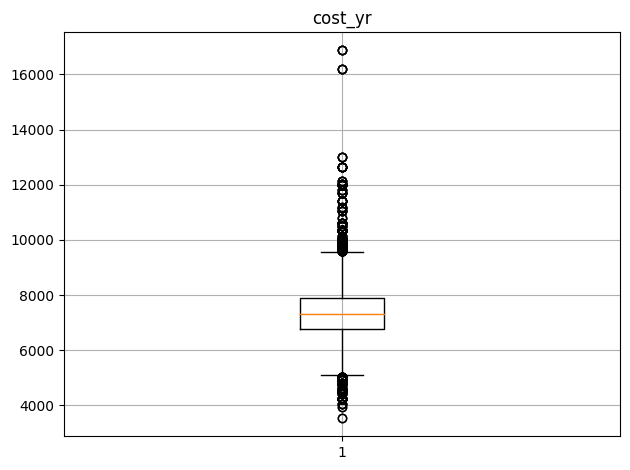

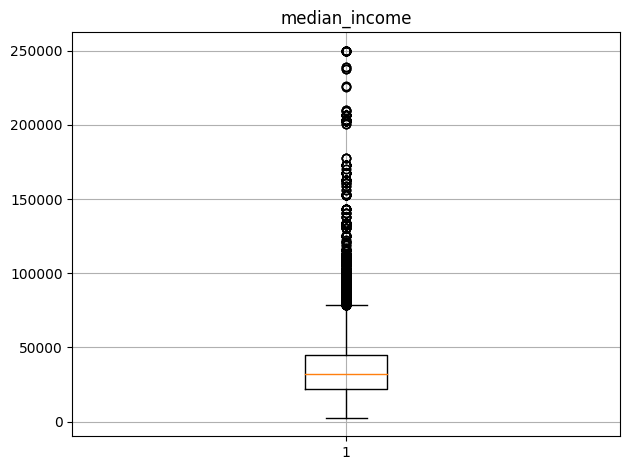

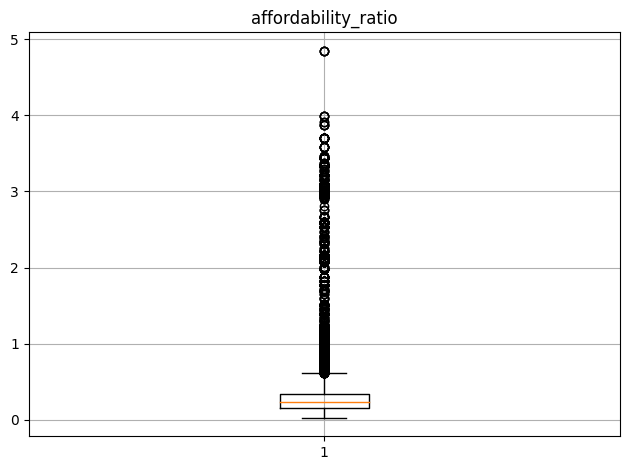

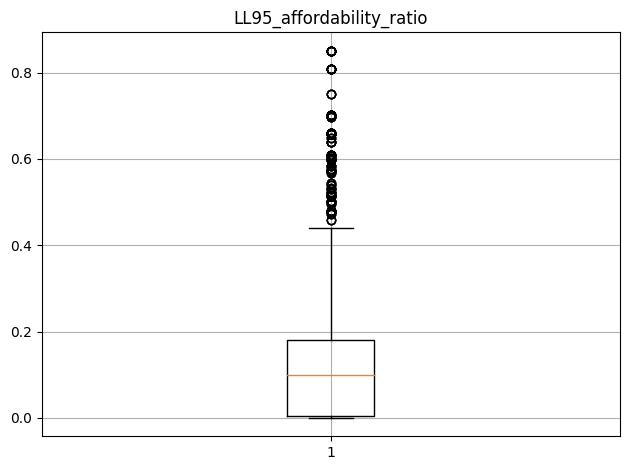

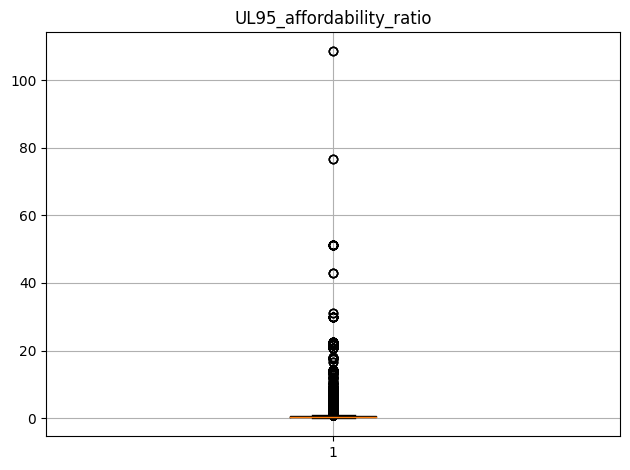

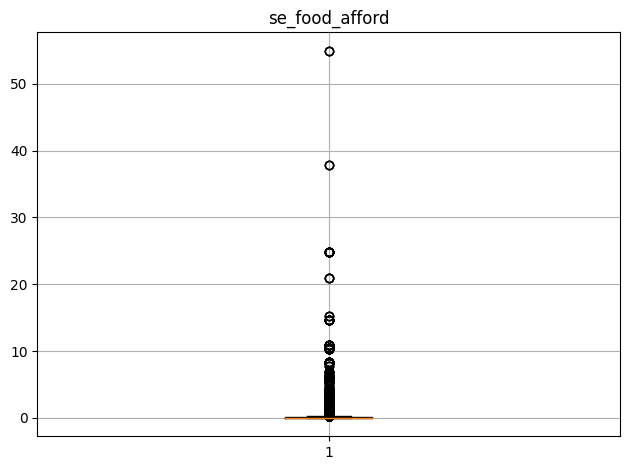

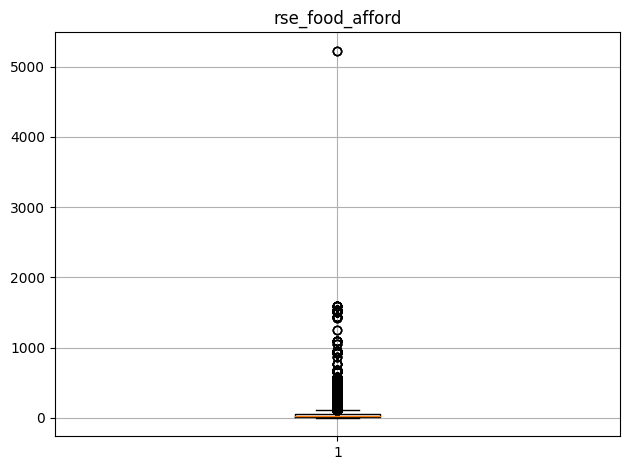

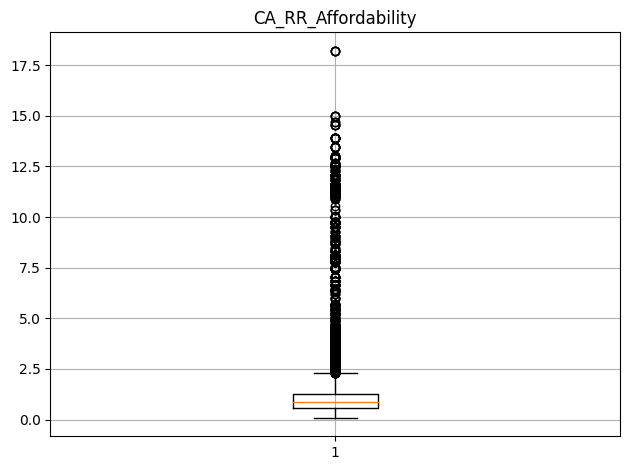

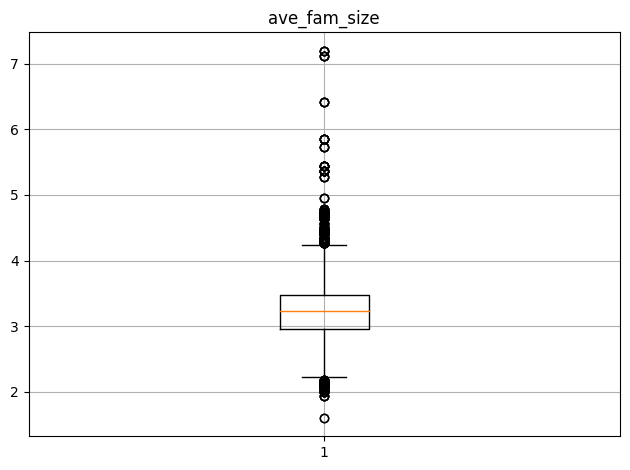

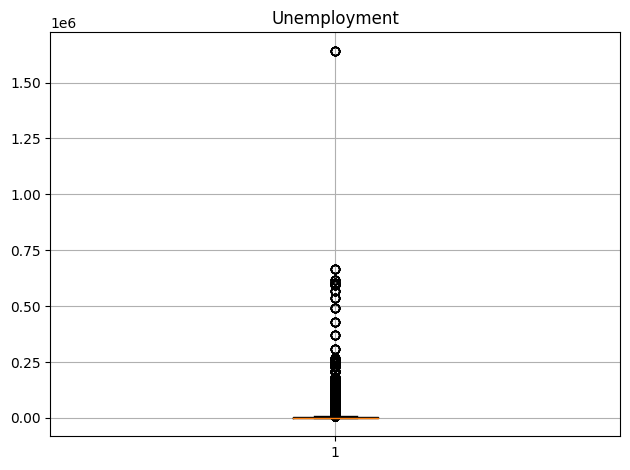

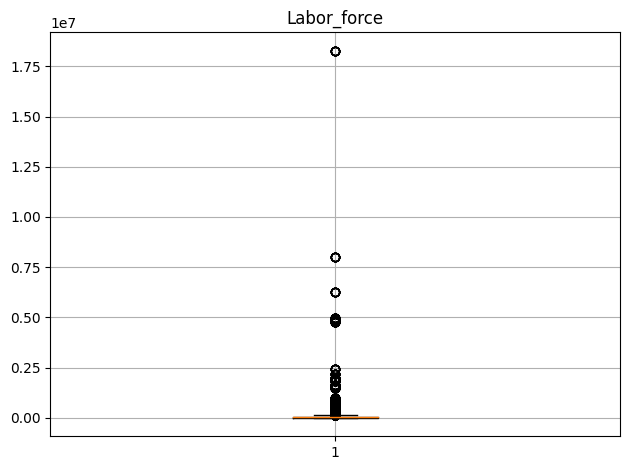

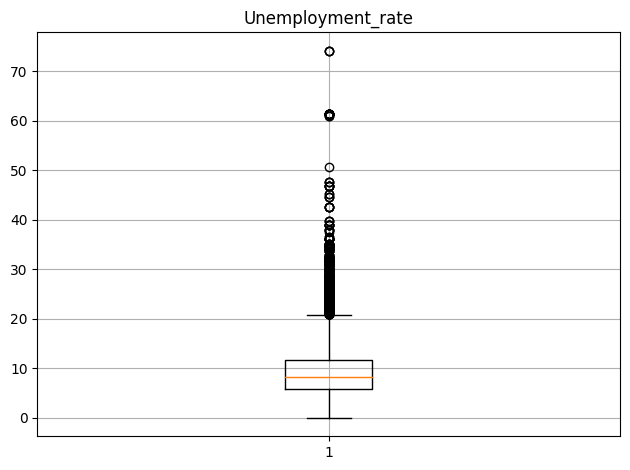

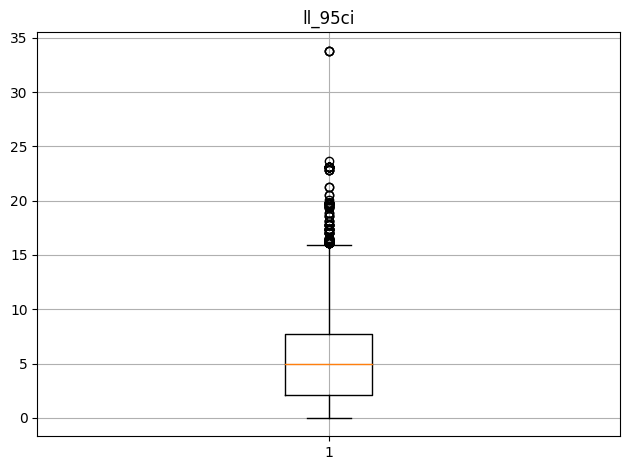

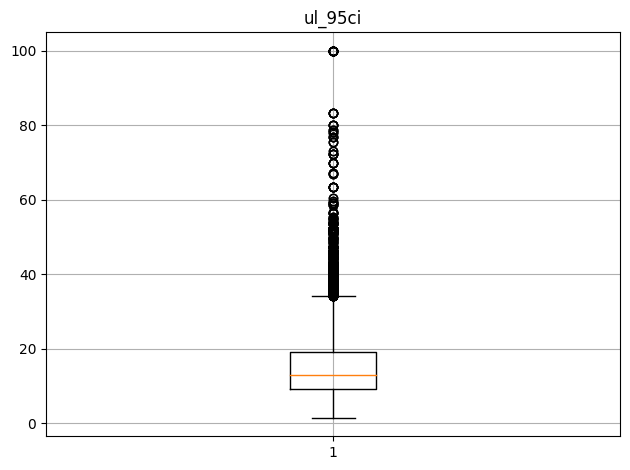

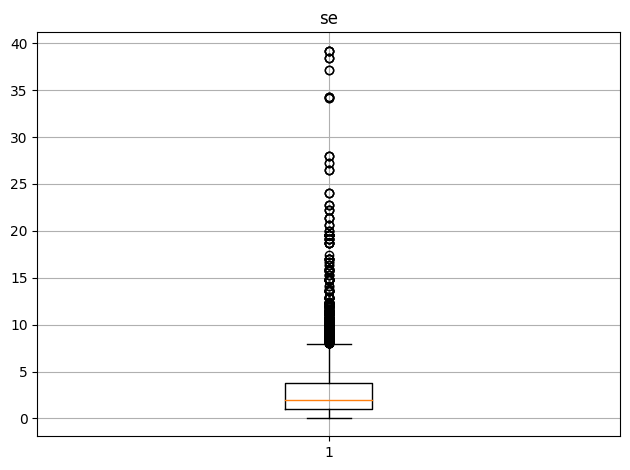

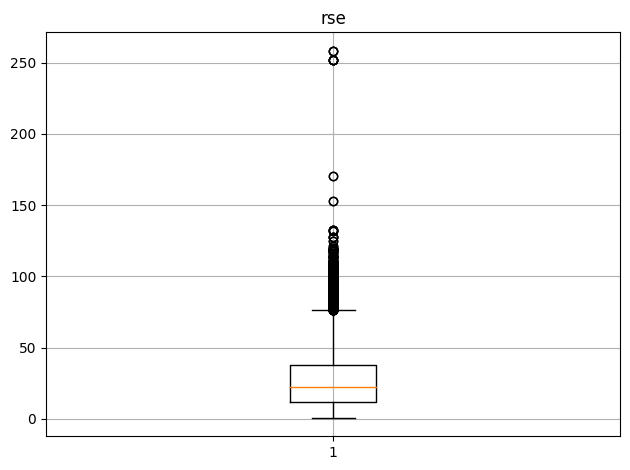

In [18]:
import matplotlib.pyplot as plt

def convert_columns_to_float(df, columns):
    for col_name in columns:
        df = df.withColumn(col_name, df[col_name].cast(FloatType()))
    return df

cols = [
    "cost_yr", "median_income", "affordability_ratio", "LL95_affordability_ratio",
    "UL95_affordability_ratio", "se_food_afford", "rse_food_afford",
    "CA_RR_Affordability", "ave_fam_size", "Unemployment", "Labor_force",
    "Unemployment_rate", "ll_95ci", "ul_95ci", "se", "rse"
]
combined_df = convert_columns_to_float(combined_df, cols)


# Recopilar datos de las columnas seleccionadas
datos = {col: [] for col in cols}

for fila in combined_df.select(cols).collect():
    for col in cols:
        if fila[col] is not None:
            try:
                datos[col].append(float(fila[col]))
            except ValueError:
                # Omite valores que no se pueden convertir a float
                continue

# Generar y mostrar boxplots
for feature_name, feature_data in datos.items():
    plt.figure()
    plt.boxplot(feature_data)
    plt.title(feature_name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Se ve que hay variables en las que los _outliers_ pueden aportar contexto al no estar muy lejos de los IQRs, pero otras en las que definitivamente hay valores muy extremos.

In [19]:

# Calcular los límites IQR para cada columna
iqr_bounds = {}
for col in cols:
    q1, q3 = combined_df.approxQuantile(col, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    iqr_bounds[col] = (lower_bound, upper_bound)

# Imprimir los límites IQR
for col, bounds in iqr_bounds.items():
    print(f"Límites IQR para {col}: Inferior = {bounds[0]}, Superior = {bounds[1]}")

Límites IQR para cost_yr: Inferior = 5069.904541015625, Superior = 9563.941650390625
Límites IQR para median_income: Inferior = -10960.0, Superior = 76784.0
Límites IQR para affordability_ratio: Inferior = -0.10571698844432831, Superior = 0.5979805737733841
Límites IQR para LL95_affordability_ratio: Inferior = -0.26535914093255997, Superior = 0.44226523488759995
Límites IQR para UL95_affordability_ratio: Inferior = -0.21607037633657455, Superior = 0.9676124826073647
Límites IQR para se_food_afford: Inferior = -0.10543510038405657, Superior = 0.23831609915941954
Límites IQR para rse_food_afford: Inferior = -44.031625747680664, Superior = 103.56064414978027
Límites IQR para CA_RR_Affordability: Inferior = -0.39683154225349426, Superior = 2.2446500957012177
Límites IQR para ave_fam_size: Inferior = 2.1950000524520874, Superior = 4.235000014305115
Límites IQR para Unemployment: Inferior = -5053.0, Superior = 9387.0
Límites IQR para Labor_force: Inferior = -64202.5, Superior = 117969.5
Lími

Aquí podemos observar que realmente los datos tienen una distribución muy marcada con valores fuera de los límites superior e inferiores por lo que hay muchas situaciones atipicas.


In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
clean_df = combined_df.na.drop(subset=cols)

clean_df = convert_columns_to_float(clean_df, cols)

# Vectorización
assembler = VectorAssembler(inputCols=cols, outputCol="features")
vector_df = assembler.transform(clean_df).select("features")

# Cálculo de la matriz de correlación de Pearson
try:
    pearson_matrix = Correlation.corr(vector_df, 'features').head()[0]
except Exception as e:
    print("Error al calcular la correlación:", e)
else:
    # Convertir la matriz de correlación a un array para visualización
    corr_matrix_array = pearson_matrix.toArray()

    # Visualizar la matriz de correlación como un heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix_array, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=cols, yticklabels=cols)
    plt.title("Matriz de Correlación de Pearson")
    plt.tight_layout()
    plt.show()

De esta matriz podemos sacar varias conclusiones pero voy a resaltar las más destacables.
Tenemos 4 princiaples correlaciones fuertes positivas:
* cost_yr con ave_fam_size existe una gran correlación positiva, con estos podemos concluir que a medida que aumenta el tamaño promedio de la familia, también lo hace el costo anualm, lo cual es bastante lógico.

* Unemployment con Labor_force: Fuertemente correlacionadas, ya que el desempleo está directamente relacionado con la fuerza laboral total.

* ll_95ci con ul_95ci: Indicando que donde un límite de confianza bajo aumenta, el alto también lo hace.


Tenemos una relación fuerte negativa: 
* ll_95ci con rse es una correlación negativa considerable, a medida que el límite inferior de confianza 95 aumenta, el error relativo estándar tiende a disminuir.

Relaciones menos notables pero igualmente importante:
* median_income y affordability_ratio: No estan fuerte como las otras pero sugiere que un mayor ingreso mediano reduce el ratio de asequibilidad.

El resto de correlaciones están cerca de 0 por lo que no vale mucho la pena destacar nada 

## Primer modelo (Random Forest)

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# Leer el DataFrame combinado desde PostgreSQL
df_combined_verificado = leer_combined_postgres()

# Definir columnas a convertir
cols = [
    "cost_yr", "median_income", "affordability_ratio", "LL95_affordability_ratio",
    "UL95_affordability_ratio", "se_food_afford", "rse_food_afford",
    "CA_RR_Affordability", "ave_fam_size", "Unemployment", "Labor_force",
    "Unemployment_rate", "ll_95ci", "ul_95ci", "se", "rse"
]

# Convertir columnas a float
df_combined_verificado = convert_columns_to_float(df_combined_verificado, cols)

# Indexar la variable objetivo
indexer = StringIndexer(inputCol="inseguridad_alimentaria", outputCol="label")
df = indexer.fit(df_combined_verificado).transform(df_combined_verificado)

# Prepara las características
feature_columns = ['median_income', 'Unemployment_rate', 'Labor_force', 'ave_fam_size']  # Asegúrate de incluir las columnas correctas
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# Divide el dataset en train y test
(train_df, test_df) = df.randomSplit([0.8, 0.2], seed=42)

# Configura el modelo de Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100)

# Configura la validación cruzada con 5 particiones
paramGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # 5-Fold

# Ajusta el modelo y valida
cv_model = crossval.fit(train_df)

# Realiza predicciones en el conjunto de prueba
predictions = cv_model.transform(test_df)

# Evalúa el modelo
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"Área bajo la curva ROC: {roc_auc}")

# Muestra algunas predicciones
predictions.select("geoname", "region_name", "median_income", "prediction", "probability", "label").show(5, truncate=False)



# Calcula conteos necesarios
tp = predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

# Calcula métricas básicas
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Calcula métricas adicionales
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

# Evaluadores para ROC y PR AUC
evaluator_roc_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_pr_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")

roc_auc = evaluator_roc_auc.evaluate(predictions)
pr_auc = evaluator_pr_auc.evaluate(predictions)

# Reporte de métricas
print("\nMétricas en conjunto de validación final:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precisión: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# Leer el DataFrame combinado desde PostgreSQL asumimos que la función existe y es correcta
df_combined_verificado = leer_combined_postgres()

# Definir columnas a convertir
cols = [
    "cost_yr", "median_income", "affordability_ratio", "LL95_affordability_ratio",
    "UL95_affordability_ratio", "se_food_afford", "rse_food_afford",
    "CA_RR_Affordability", "ave_fam_size", "Unemployment", "Labor_force",
    "Unemployment_rate", "ll_95ci", "ul_95ci", "se", "rse"
]

# Convertir columnas a float
df_combined_verificado = convert_columns_to_float(df_combined_verificado, cols)

# Convertir "Desconocido" en las columnas de características a -1
def convert_unknowns_to_numeric(df, columns):
    for column in columns:
        df = df.withColumn(column, F.when(F.col(column) == "Desconocido", -1).otherwise(F.col(column).cast("float")))
    return df

# Especificar las columnas que pueden tener valores "Desconocido"
columns_to_transform = ['median_income', 'Unemployment_rate', 'Labor_force', 'ave_fam_size', 'rse_food_afford']
df_combined_verificado = convert_unknowns_to_numeric(df_combined_verificado, columns_to_transform)

# Indexar la variable objetivo
indexer = StringIndexer(inputCol="inseguridad_alimentaria", outputCol="label")
df = indexer.fit(df_combined_verificado).transform(df_combined_verificado)

# Prepara las características
feature_columns = ['median_income', 'Unemployment_rate', 'Labor_force', 'ave_fam_size']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)
df_combined_verificado.select('median_income', 'Unemployment_rate', 'Labor_force', 'ave_fam_size', 'rse_food_afford').show(5)


In [52]:


# Divide el dataset en train y test
(train_df, test_df) = df.randomSplit([0.8, 0.2], seed=42)

# Configura el modelo de Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100)

# Configura la validación cruzada con 5 particiones
paramGrid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # 5-Fold

# Ajusta el modelo y valida
cv_model = crossval.fit(train_df)

# Realiza predicciones en el conjunto de prueba
predictions = cv_model.transform(test_df)

# Evalúa el modelo
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"Área bajo la curva ROC: {roc_auc}")

# Muestra algunas predicciones
predictions.select("geoname", "region_name", "median_income", "prediction", "probability", "label").show(5, truncate=False)

# Calcula conteos necesarios
tp = predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

Área bajo la curva ROC: 0.9969411523671436


+-------------+-------------------+-------------+----------+-----------------------------------------+-----+
|geoname      |region_name        |median_income|prediction|probability                              |label|
+-------------+-------------------+-------------+----------+-----------------------------------------+-----+
|Acton CDP    |Southern California|12500.0      |1.0       |[0.04406178111621448,0.9559382188837856] |1.0  |
|Acton CDP    |Southern California|12500.0      |1.0       |[0.04406178111621448,0.9559382188837856] |1.0  |
|Adelanto city|Southern California|17310.0      |1.0       |[0.024995719771944494,0.9750042802280555]|1.0  |
|Adelanto city|Southern California|17310.0      |1.0       |[0.0194659085455128,0.9805340914544872]  |1.0  |
|Adelanto city|Southern California|17310.0      |1.0       |[0.0194659085455128,0.9805340914544872]  |1.0  |
+-------------+-------------------+-------------+----------+-----------------------------------------+-----+
only showing top 5 

In [42]:


# Calcula métricas básicas
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Calcula métricas adicionales
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

# Evaluadores para ROC y PR AUC
evaluator_roc_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_pr_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")

roc_auc = evaluator_roc_auc.evaluate(predictions)
pr_auc = evaluator_pr_auc.evaluate(predictions)

# Reporte de métricas
print("\nMétricas en conjunto de validación final:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precisión: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")


Métricas en conjunto de validación final:
ROC AUC: 0.9462
PR AUC: 0.9311
Precisión: 0.9321
Recall: 0.9173
F1 Score: 0.9004
Specificity: 0.9395
False Positive Rate (FPR): 0.0605
False Negative Rate (FNR): 0.0827


Elegimos Random Forest porque va muy acorde al tamaño de nuestro dataset que no es muy grande, por lo que es un tiempo de entrenado razonable, incluyendo el hecho de que nos da métricas de suma importancia para identificar que factores influyen más en la predicción de la diabetes. Ahorita vamos a preparar el modelo para entrenamiento así como su validación 


## Regresión Logística


In [69]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when, expr

# Configura la sesión de Spark
spark = SparkSession.builder \
    .appName("Logistic Regression with Metrics") \
    .config("spark.jars", "path/to/postgresql-<version>.jar") \
    .getOrCreate()

# Suponiendo que la función 'leer_combined_postgres' está definida
df_combined_verificado = leer_combined_postgres()

# Convertir columnas a float y preparar los datos
cols = [
    "cost_yr", "median_income", "affordability_ratio", "LL95_affordability_ratio",
    "UL95_affordability_ratio", "se_food_afford", "rse_food_afford",
    "CA_RR_Affordability", "ave_fam_size", "Unemployment", "Labor_force",
    "Unemployment_rate", "ll_95ci", "ul_95ci", "se", "rse"
]
df_combined_verificado = convert_columns_to_float(df_combined_verificado, cols)

# Indexa la etiqueta
indexer = StringIndexer(inputCol="inseguridad_alimentaria", outputCol="label")
df_indexed = indexer.fit(df_combined_verificado).transform(df_combined_verificado)

# Columna de características
feature_columns = ['affordability_ratio']  # Amplía según sea necesario
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df_indexed)

# División del dataset
(train_df, test_df) = df.randomSplit([0.8, 0.2], seed=42)

# Modelo de regresión logística
lr = LogisticRegression(featuresCol='features', labelCol='label', regParam=0.7)
lr_model = lr.fit(train_df)

# Predicciones
predictions = lr_model.transform(test_df)

# Evaluadores
evaluator_roc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
evaluator_pr = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")

# ROC AUC
roc_auc = evaluator_roc.evaluate(predictions)
# PR AUC
pr_auc = evaluator_pr.evaluate(predictions)

# Calcula demás métricas
tp = predictions.filter((col('label') == 1) & (col('prediction') == 1)).count()
tn = predictions.filter((col('label') == 0) & (col('prediction') == 0)).count()
fp = predictions.filter((col('label') == 0) & (col('prediction') == 1)).count()
fn = predictions.filter((col('label') == 1) & (col('prediction') == 0)).count()

# Precision, Recall, F1 Score, Specificity, FPR, FNR
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

# Imprimir métricas
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Detiene la sesión de Spark
spark.stop()

25/07/31 04:15:35 ERROR SparkContext: Failed to add path/to/postgresql-<version>.jar to Spark environment
java.io.FileNotFoundException: Jar /src/path/to/postgresql-<version>.jar not found
	at org.apache.spark.SparkContext.addLocalJarFile$1(SparkContext.scala:1963)
	at org.apache.spark.SparkContext.addJar(SparkContext.scala:2018)
	at org.apache.spark.SparkContext.$anonfun$new$12(SparkContext.scala:502)
	at org.apache.spark.SparkContext.$anonfun$new$12$adapted(SparkContext.scala:502)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:502)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstr

Lectura de la tabla de datos combinados en PostgreSQL


ROC AUC: 1.0000
PR AUC: 1.0000
Precisión: 1.0000
Recall: 0.0507
F1 Score: 0.0966
Specificity: 1.0000
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.9493


## Obtencion de datos

In [ ]:
#Tomamos los datos
feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# Dividimos un 80% en datos de entrenamiento y dejamos un 20% para la validación
train_val, validation_test = df.randomSplit([0.8, 0.2], seed=42)

randomforest = RandomForestClassifier(
    featuresCol="features",
    labelCol="Outcome",
    seed=42
)

pipeline = Pipeline(stages=[assembler, randomforest])

evaluator = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)

# K-Fold Cross Validation con k=5
paramGrid = ParamGridBuilder() \
    .addGrid(randomforest.numTrees, [50, 100, 150]) \
    .addGrid(randomforest.maxDepth, [5, 10, 15]) \
    .addGrid(randomforest.maxBins, [32, 64]) \
    .build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,  
    seed=42
)


## Entrenamiento 


In [ ]:

# Entrenar Cross Validation
cv_model = crossval.fit(train_val)


best_model = cv_model.bestModel
best_rf = best_model.stages[-1]
#Reporte del entrenamiento
print("\nMejores parámetros del modelo:")
print(f"Número de árboles: {best_rf.getNumTrees}")
print(f"Profundidad máxima: {best_rf.getMaxDepth()}")
print(f"Número máximo de bins: {best_rf.getMaxBins()}")


En el proceso dura un tiempo considerable ya que promedia los 150 número de arboles con una profundidad de 5.
Una vez entrenado el modelo evaluamos su rendimiento, es importante considerar que la predicción es de una varioable binaria por lo tanto usamos esta validación específica que tiene PysPark

In [ ]:
#Evaluar con la validación final
test_predictions = best_model.transform(validation_test)

# Métricas de evaluación 
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)
roc_auc = evaluator_roc.evaluate(test_predictions)

evaluator_pr = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderPR"
)
pr_auc = evaluator_pr.evaluate(test_predictions)

# Evaluador multiclase para precisión
multi_evaluator = MulticlassClassificationEvaluator(
    labelCol="Outcome",
    predictionCol="prediction"
)

accuracy = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "f1"})




# Reporte de métricas
print("\nMétricas en conjunto de validación final:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precisión: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Importancia de características
importances = best_rf.featureImportances
importance_dict = {feature: importance for feature, importance in zip(feature_cols, importances)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nImportancia de características:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

## Guardado en base

In [ ]:
# Guardar predicciones para RF
rf_output = test_predictions.select(
    *feature_cols,
    col("Outcome"),
    col("prediction").alias("prediccion")
)


rf_output.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "pword") \
    .option("dbtable", "modelo1") \
    .save()


print("Predicciones de Random Forest guardadas en tabla 'modelo1'")

## Segundo modelo: Regresión Logística

En este momento realmente hacemos lo mismo que con Random Forest de tomar los datos para el entrenamiento del modelo 
pero decidimos también entrenar con este modelo por varios motivos.
Primero al contrario de RandomForest es mucho más rápido que aunque con este dataset tampoco sea un tiempo irrazonable si se nota bastante la diferencia, y es más facil explicar cada variable por los "odds ratios" para ver que tanto impacta la diabetes y ver si es acorde con RF. Ádemas podemos evitar un poco más el overfitting

In [ ]:
from pyspark.ml.classification import LogisticRegression


db_url = "jdbc:postgresql://host.docker.internal:5433/postgres"
db_properties = {
    "user": "postgres",
    "password": "pword",
    "driver": "org.postgresql.Driver"
}

df = spark.read.jdbc(
    url=db_url,
    table="scaledData",
    properties=db_properties
)

feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# Dividimos un 80% en datos de entrenamiento y dejamos un 20% para la validación
train_val, test = df.randomSplit([0.8, 0.2], seed=42)


## Preparación

In [ ]:
# Regresión Logística
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Outcome",
    family="binomial",  # diabete o no por eso binaria
    maxIter=100,        
    elasticNetParam=0.8 # Mezcla entre L1 y L2
)

pipeline = Pipeline(stages=[assembler, lr])

evaluator = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)

# K-Fold Cross Validation con k=5
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5, 
    seed=42
)

## Entrenamiento

In [ ]:

# Cross Validation
print("Iniciando entrenamiento con Cross Validation...")
cv_model = crossval.fit(train_val)
print("Entrenamiento completado")

# Obtener mejor modelo
best_model = cv_model.bestModel
best_lr = best_model.stages[-1]

print("\nMejores parámetros del modelo:")
print(f"Parámetro de regularización (regParam): {best_lr.getRegParam():.4f}")
print(f"Mezcla L1/L2 (elasticNetParam): {best_lr.getElasticNetParam():.4f}")
print(f"Incluir intercepto: {best_lr.getFitIntercept()}")


## Métricas

In [ ]:

test_predictions = best_model.transform(test)

# Métricas de evaluación
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)
roc_auc = evaluator_roc.evaluate(test_predictions)

evaluator_pr = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderPR"
)
pr_auc = evaluator_pr.evaluate(test_predictions)

# Evaluador multiclase para precisión, recall, F1
multi_evaluator = MulticlassClassificationEvaluator(
    labelCol="Outcome",
    predictionCol="prediction"
)
accuracy = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "f1"})

#Reporte de métricas
print("\nMétricas en conjunto de validación final:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precisión: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

#Coeficientes del modelo
coefficients = best_lr.coefficients.toArray()
intercept = best_lr.intercept

print("\nCoeficientes del modelo:")
for feature, coef in zip(feature_cols, coefficients):
    print(f"{feature}: {coef:.4f}")
print(f"Intercepto: {intercept:.4f}")

## Guardado en base

In [ ]:
# Guardar predicciones para RF
lf_output = test_predictions.select(
    *feature_cols,
    col("Outcome"),
    col("prediction").alias("prediccion")
)


rf_output.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "pword") \
    .option("dbtable", "modelo2") \
    .save()


print("Predicciones de LogReg guardadas en tabla 'modelo2'")

## Comparación modelos
### Análisis sobre el rendimiento del Random Forest
Lo que nos indica los datos es por un lado el ROC AUC es una capacidad de discriminación entre diabeticos y no diábeticos bastante sólida
El PR AUC en 0.75 es un buen desempeño en un posible desequilibio de clases-
La precisión y el recall es que hay un equilibrio entre falsos positivios y falsos negativos de un 76%
El F1 Score nos confirma lo anterior.

Sobre la importancia de las características podemos concluir lo siguiente, la Glucosa domina el poder predictivo siendo el más fuerte
Seguido por la edad y el BMI, que siguen aportando bastante pero en menos medida, por último la presión sanguínea y el "Skin Thickness" son los que tienen una contribución 
mucho menor.
Lo cual usando la lógica de la enfermedad tiene sentido que el mayor factor sea la glucosa, el peso y edad de la persona.

### Sobre la Regresión Logística
En comparación con RF se ve que regresión logística funciona en todas las métricas, teniendo una mayor discriminación, con así como precisión y mejor balance.
Al igual que en el RF la glucosa, el BMI son los mejores, pero es curioso ver que en este caso posiciona los embarazos por encima de la edad.
Los coeficientes en 0 también es algo que indica que no hay relación alguna entre variables como `BloodPressure` o `SkinThickness` y la variable que se buscaba predecir.

## Confirmación de los datos guardados en la base de datos
Usando el cliente pgAdmin, sabiendo el puerto y las credenciales de la conexión a postgres, se pueden ver las tablas que se almacenaron, e incluso hacer consultas sobre ellas.

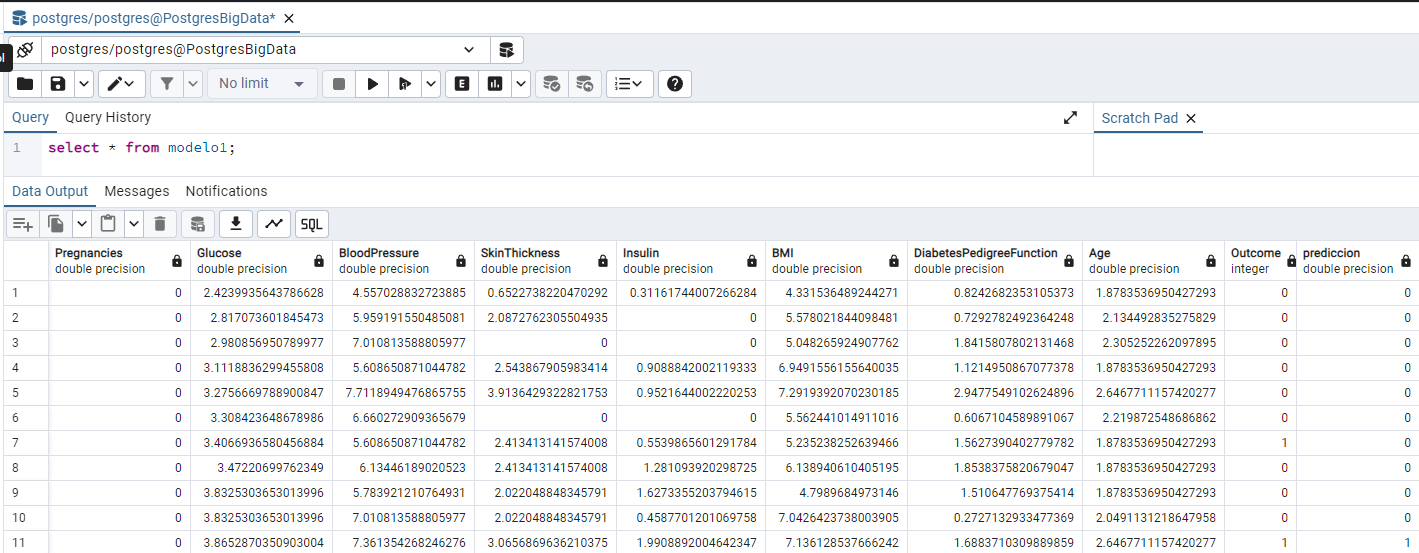

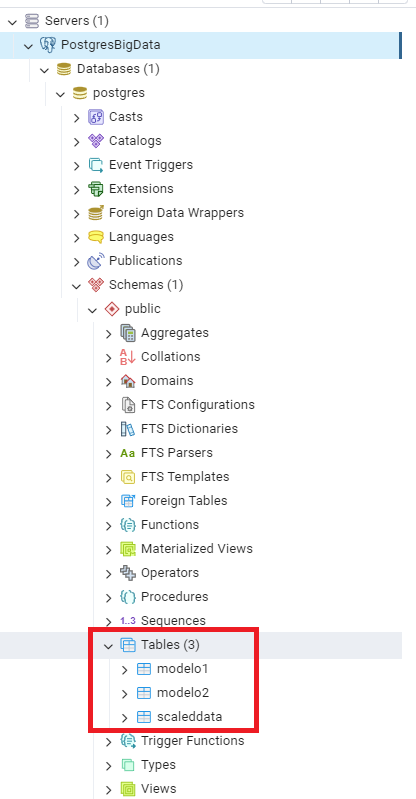